In [1]:
from ucimlrepo import fetch_ucirepo
import polars as pl
import polars.selectors as cs
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

heart_disease = fetch_ucirepo(id=45)
raw = pl.from_pandas(heart_disease.data.original)

In [45]:
OUTLIER_THRESHOLD = 2  # Standard deviations from the mean

data = raw.drop_nulls()
data = data.with_columns(
    (pl.col("num") >= 1).cast(pl.Int64).alias("num"),
    cs.exclude("sex", "fbs", "exang", "num").map_batches(lambda col: (col - col.mean()) / col.std()),
)
data = data.filter(pl.all_horizontal(cs.exclude("sex", "fbs", "exang", "num").abs() <= OUTLIER_THRESHOLD))
data.describe()

statistic,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",197.0,197.0,197.0,197.0,197.0,197.0,197.0,197.0,197.0,197.0,197.0,197.0,197.0,197.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",-0.094678,0.664975,0.135865,-0.196795,-0.03153,0.096447,-0.027228,0.11637,0.28934,-0.231774,-0.244128,-0.201773,-0.104569,0.406091
"""std""",0.913207,0.473202,0.812672,0.813378,0.804878,0.295955,1.004644,0.86456,0.454611,0.798941,0.807098,0.750061,0.98252,0.492353
"""min""",-1.938409,0.0,-1.200433,-1.784268,-1.891437,0.0,-1.001728,-1.944041,0.0,-0.905184,-0.974938,-0.72076,-0.892713,0.0
"""25%""",-0.833404,0.0,-0.164013,-0.65832,-0.679843,0.0,-1.001728,-0.418425,0.0,-0.905184,-0.974938,-0.72076,-0.892713,0.0
"""50%""",-0.059901,1.0,-0.164013,-0.095345,-0.083661,0.0,-1.001728,0.278999,0.0,-0.562167,-0.974938,-0.72076,-0.892713,0.0
"""75%""",0.603102,1.0,0.872408,0.467629,0.454826,0.0,1.008496,0.802067,1.0,0.295376,0.642696,0.344243,1.170601,1.0
"""max""",1.818607,1.0,0.872408,1.593577,1.820274,1.0,1.008496,1.673847,1.0,1.838953,0.642696,1.409246,1.170601,1.0


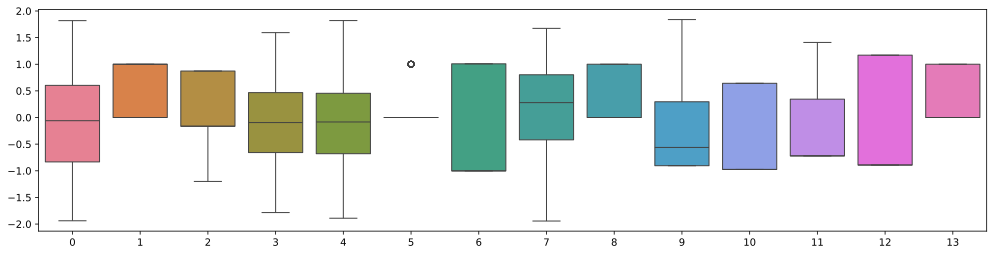

In [46]:
fig, ax = plt.subplots(1, figsize=(17, 4))
ax = sns.boxplot(data=data)
plt.show()

In [47]:
batch_size = 4
X = data[:, :-1].to_torch().float()
y = data[:, -1].to_torch().float()[:, None]  # make it a column vector
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0], shuffle=False)
print(X.shape, y.shape)

torch.Size([197, 13]) torch.Size([197, 1])


# Neural Network

In [48]:
class HeartDiseaseNN(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.input = nn.Linear(input_size, 32)
        self.fc1 = nn.Linear(32, 64)
        self.fc2 = nn.Linear(64, 16)
        self.output = nn.Linear(16, 1)

    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.output(x)

In [49]:
# test the model on a bit of data
net = HeartDiseaseNN(13)

X, y = next(iter(train_loader))
y_hat = net(X)
print(y_hat.shape, y.shape)

# test the loss function
lossfun = nn.BCEWithLogitsLoss()
lossfun(y_hat, y)

torch.Size([4, 1]) torch.Size([4, 1])


tensor(0.6842, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [50]:
net = HeartDiseaseNN(13)
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.01)
lossfun = nn.BCEWithLogitsLoss()
num_epochs = 500

# initialize losses and accuracies
train_loss = torch.zeros(num_epochs)
test_loss = torch.zeros(num_epochs)
train_acc = torch.zeros(num_epochs)
test_acc = torch.zeros(num_epochs)

for epoch_i in range(num_epochs):
    batch_loss = []
    for X, y in train_loader:
        # Forward pass
        y_hat = net(X)
        loss = lossfun(y_hat, y)
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Loss collection
        batch_loss.append(loss.item())
        # Train accuracy
        y_pred = torch.sigmoid(y_hat) >= 0.5
        train_acc[epoch_i] = 100 * (y_pred == y).float().mean().item()
    train_loss[epoch_i] = torch.mean(torch.tensor(batch_loss))

    ## now for the test
    X, y = next(iter(test_loader))
    y_hat = net(X)

    # test loss
    loss = lossfun(y_hat, y)
    test_loss[epoch_i] = loss.item()

    # test accuracy
    predictions = (torch.sigmoid(y_hat) > 0.5).float()
    test_acc[epoch_i] = 100 * (predictions == y).float().mean().item()

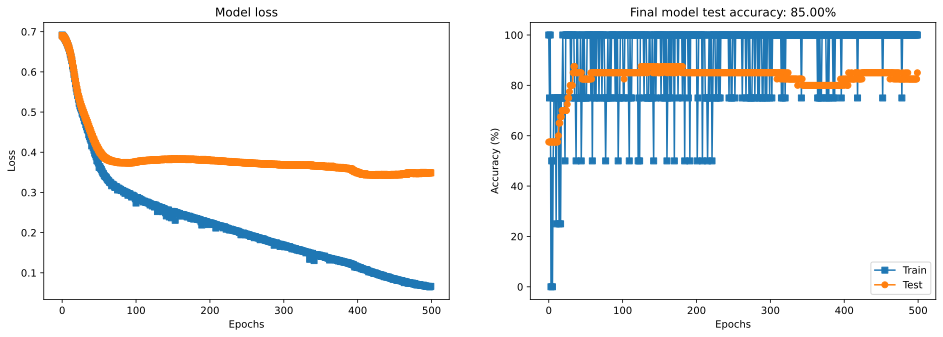

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(train_loss, "s-", label="Train")
ax[0].plot(test_loss, "s-", label="Test")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("Model loss")

ax[1].plot(train_acc, "s-", label="Train")
ax[1].plot(test_acc, "o-", label="Test")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_title(f"Final model test accuracy: {test_acc[-1]:.2f}%")
ax[1].legend()

plt.show()